In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import get_connection
import os
import requests

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

Bonus: 
1. Using the store item demand data, create a forecast of `sales_total` and `quantity` for 2018 using the `Previous Cycle` approach.  .  
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.

In [2]:
def get_saas_data():
    
    if os.path.isfile('saas.csv'):
        
        return pd.read_csv('saas.csv')

In [3]:
df = get_saas_data()

In [4]:
df.columns.tolist()

['Month_Invoiced', 'Customer_Id', 'Invoice_Id', 'Subscription_Type', 'Amount']

In [5]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
working_df = df.drop(columns = ['Customer_Id', 'Invoice_Id', 'Subscription_Type'])
working_df

,Month_Invoiced,Amount
0,2014-01-31,0.0
1,2014-01-31,10.0
2,2014-01-31,0.0
3,2014-01-31,0.0
4,2014-01-31,5.0
...,...,...
790453,2017-12-31,0.0
790454,2017-12-31,0.0
790455,2017-12-31,15.0
790456,2017-12-31,0.0


In [7]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Month_Invoiced  790458 non-null  object 
 1   Amount          790458 non-null  float64
dtypes: float64(1), object(1)
memory usage: 12.1+ MB


In [8]:
working_df.columns = working_df.columns.str.lower()
working_df

,month_invoiced,amount
0,2014-01-31,0.0
1,2014-01-31,10.0
2,2014-01-31,0.0
3,2014-01-31,0.0
4,2014-01-31,5.0
...,...,...
790453,2017-12-31,0.0
790454,2017-12-31,0.0
790455,2017-12-31,15.0
790456,2017-12-31,0.0


In [9]:
working_df['month_invoiced']= pd.to_datetime(working_df['month_invoiced'])
working_df.dtypes

month_invoiced    datetime64[ns]
amount                   float64
dtype: object

In [10]:
working_df = working_df.set_index('month_invoiced').sort_index()
working_df

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
...,...
2017-12-31,0.0
2017-12-31,0.0
2017-12-31,15.0


In [19]:
df_resampled = working_df.resample('M')['amount'].sum()
df_resampled= pd.DataFrame(df_resampled)
df_resampled.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [20]:
df_resampled.shape

(48, 1)

In [21]:
df_resampled.dtypes

amount    float64
dtype: object

In [24]:
train_size = int(round(df_resampled.shape[0] * 0.5))

# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))

# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))

train_size, validate_size, test_size

(24, 14, 10)

In [25]:
len(df_resampled) == train_size + validate_size + test_size

True

In [26]:
validate_end_index = train_size + validate_size
validate_end_index

38

In [28]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [31]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [32]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [33]:
print(df_resampled.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


In [34]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,amount
month_invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


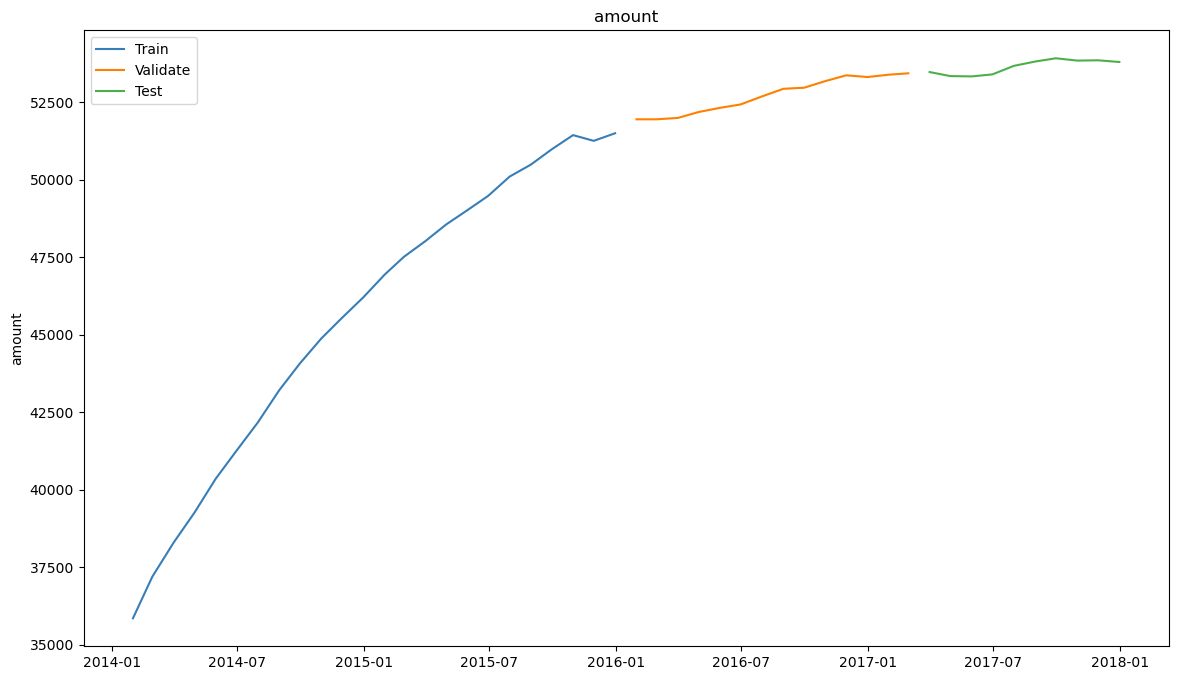

In [35]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Last observed value model

In [39]:
train['amount'][-1:][0]

51505.0

In [40]:
last_amount = train['amount'][-1:][0]

In [41]:
yhat_df = pd.DataFrame(
    {'amount': last_amount},
    index=validate.index)

yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


In [44]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [43]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [45]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [47]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

amount -- RMSE: 1343


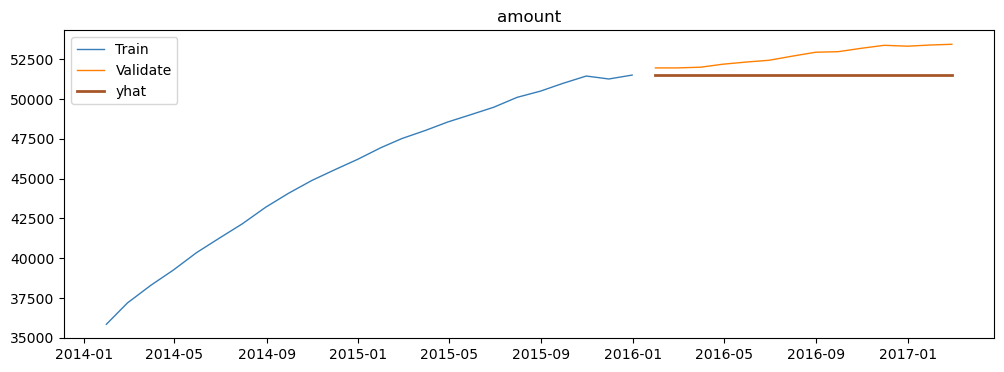

In [46]:
for col in train.columns:
    plot_and_eval(col)

In [48]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


### Simple average model

In [52]:
avg_amount = round(train['amount'].mean(), 2)
avg_amount

45568.54

In [53]:
def make_baseline_predictions(amount_predictions=None):
    yhat_df = pd.DataFrame({'amount': amount_predictions},
                          index=validate.index)
    return yhat_df

In [54]:
yhat_df = make_baseline_predictions(avg_amount)

In [55]:
yhat_df

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54
2016-06-30,45568.54
2016-07-31,45568.54
2016-08-31,45568.54
2016-09-30,45568.54


amount -- RMSE: 7181


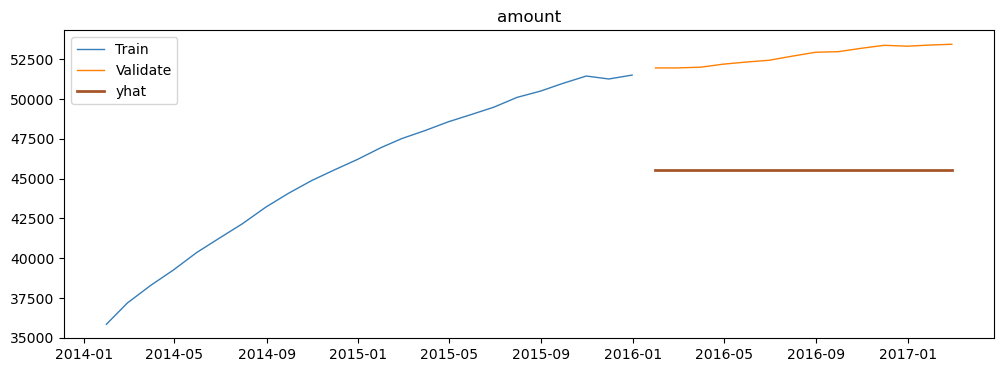

In [56]:
for col in train.columns:
    plot_and_eval(col)

In [57]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


### Moving Average Model

In [62]:
period=3
train['amount'].rolling(period).mean()

month_invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
Freq: M, Name: amount, dtype: float64

In [63]:
train['amount'].rolling(period).mean()[-1]

51403.333333333336

In [64]:
# Saving the last quater (3 months) moving average for each column
rolling_amount = round(train['amount'].rolling(period).mean()[-1], 2)

print(rolling_amount)

51403.33


In [65]:
yhat_df = make_baseline_predictions(rolling_amount)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


amount -- RMSE: 1436


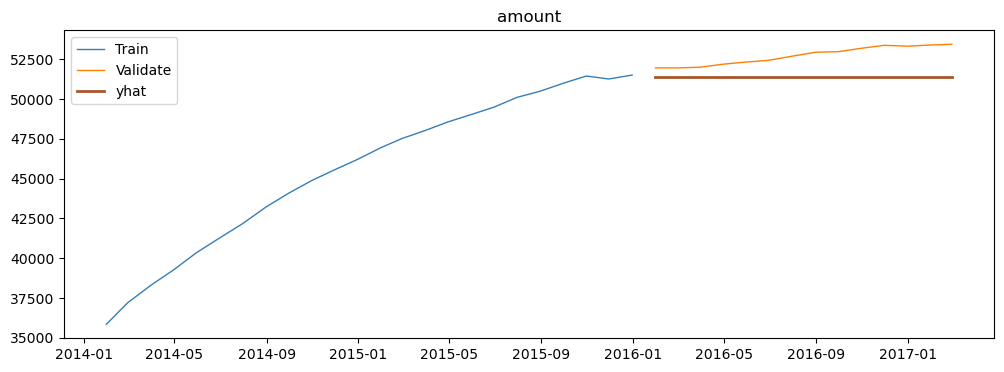

In [66]:
for col in train.columns:
    plot_and_eval(col)

In [67]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1Q_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,1Q_moving_avg,amount,1436.0


In [68]:
periods = [1, 2, 6, 9, 12]

for p in periods: 
    rolling_amount = round(train['amount'].rolling(p).mean()[-1], 2)
    
    yhat_df = make_baseline_predictions(rolling_amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [69]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,1Q_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,6_month_moving_avg,amount,1847.0
6,9_month_moving_avg,amount,2473.0
7,12_month_moving_avg,amount,3164.0


In [73]:
best_amount_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()
best_amount_rmse

1343.0

In [74]:
eval_df[eval_df.rmse == best_amount_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0


### Holts winter trend model

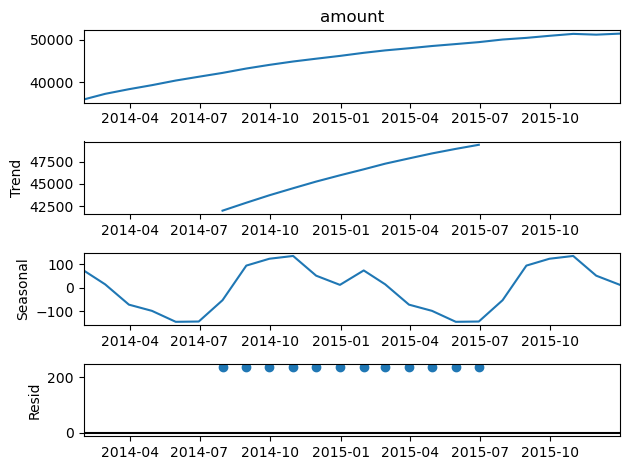

In [77]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [78]:
model = Holt(train['amount'], exponential=False, damped=True)
model = model.fit(optimized=True)

In [79]:
yhat_amount = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [82]:
validate.shape

(14, 1)

In [81]:
yhat_amount

2016-01-31    51748.618256
2016-02-29    51961.996333
2016-03-31    52173.347323
2016-04-30    52382.690483
2016-05-31    52590.044887
2016-06-30    52795.429429
2016-07-31    52998.862822
2016-08-31    53200.363602
2016-09-30    53399.950129
2016-10-31    53597.640587
2016-11-30    53793.452991
2016-12-31    53987.405181
2017-01-31    54179.514829
2017-02-28    54369.799440
Freq: M, dtype: float64

amount -- RMSE: 3164


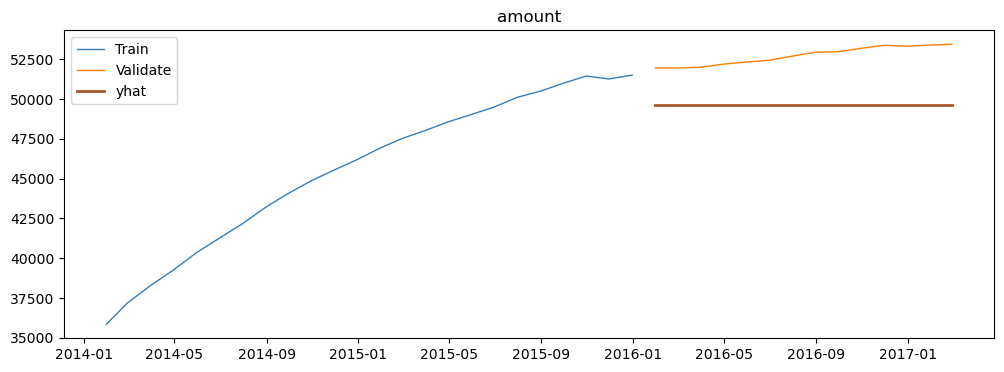

In [83]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [84]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [86]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0
2,1Q_moving_avg,amount,1436.0
4,2_month_moving_avg,amount,1455.0
5,6_month_moving_avg,amount,1847.0
6,9_month_moving_avg,amount,2473.0
7,12_month_moving_avg,amount,3164.0
8,holts_optimized,amount,3164.0
1,simple_average,amount,7181.0


In [88]:
hst_amount_fit1 = ExponentialSmoothing(train.amount, seasonal_periods=2, trend='add', seasonal='add').fit()
hst_amount_fit2 = ExponentialSmoothing(train.amount, seasonal_periods=2, trend='add', seasonal='mul').fit()
hst_amount_fit3 = ExponentialSmoothing(train.amount, seasonal_periods=2, trend='add', seasonal='add', damped=True).fit()
hst_amount_fit4 = ExponentialSmoothing(train.amount, seasonal_periods=2, trend='add', seasonal='mul', damped=True).fit()


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [89]:
results_amount=pd.DataFrame({'model':['hst_amount_fit1', 'hst_amount_fit2', 'hst_amount_fit3', 'hst_amount_fit4'],
                              'SSE':[hst_amount_fit1.sse, hst_amount_fit2.sse, hst_amount_fit3.sse, hst_amount_fit4.sse]})
results_amount

,model,SSE
0,hst_amount_fit1,1.829513e+06
1,hst_amount_fit2,3.824903e+06
2,hst_amount_fit3,1.742256e+06
3,hst_amount_fit4,3.697257e+06


In [90]:
results_amount.sort_values(by='SSE')

,model,SSE
2,hst_amount_fit3,1.742256e+06
0,hst_amount_fit1,1.829513e+06
3,hst_amount_fit4,3.697257e+06
1,hst_amount_fit2,3.824903e+06


In [92]:
yhat_df = pd.DataFrame({'amount': hst_amount_fit3.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df

,amount
month_invoiced,
2016-01-31,51679.688787
2016-02-29,51990.138724
2016-03-31,52103.405690
2016-04-30,52395.842884
2016-05-31,52491.862852
2016-06-30,52767.786239
2016-07-31,52847.994423
2016-08-31,53108.778206
2016-09-30,53174.490389


amount -- RMSE: 265


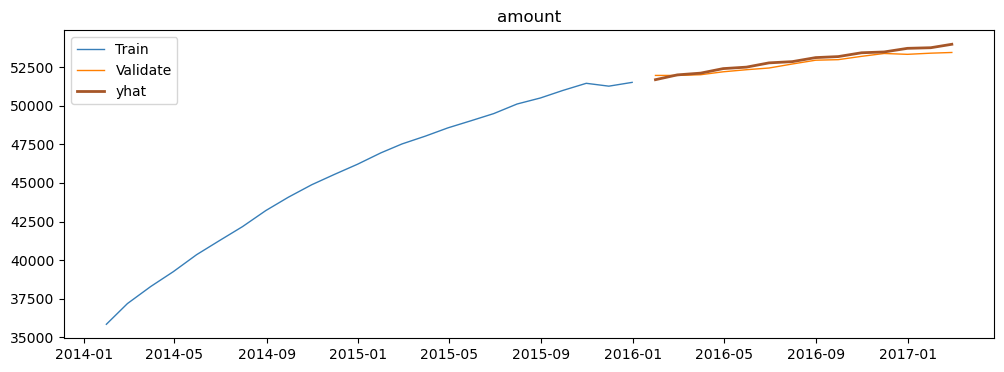

In [93]:
for col in train.columns:
    plot_and_eval(col)

In [94]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,1Q_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,6_month_moving_avg,amount,1847.0
6,9_month_moving_avg,amount,2473.0
7,12_month_moving_avg,amount,3164.0
8,holts_optimized,amount,3164.0


In [95]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [97]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,holts_seasonal_add_add,amount,265.0
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0
2,1Q_moving_avg,amount,1436.0
4,2_month_moving_avg,amount,1455.0
5,6_month_moving_avg,amount,1847.0
6,9_month_moving_avg,amount,2473.0
7,12_month_moving_avg,amount,3164.0
8,holts_optimized,amount,3164.0
1,simple_average,amount,7181.0


In [98]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [99]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [107]:
yhat_df = pd.DataFrame({'amount': hst_amount_fit3.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,amount
2016-01-31,51679.688787
2016-02-29,51990.138724
2016-03-31,52103.405690
2016-04-30,52395.842884
2016-05-31,52491.862852
2016-06-30,52767.786239
2016-07-31,52847.994423
2016-08-31,53108.778206
2016-09-30,53174.490389
2016-10-31,53421.394414


In [108]:
validate.head(1)

,amount
month_invoiced,
2016-01-31,51955.0


In [109]:
test.head(1)

,amount
month_invoiced,
2017-03-31,53480.0


In [110]:
yhat_df = yhat_df['2017-03-31':]

In [111]:
yhat_df

,amount
2017-03-31,53999.816992
2017-04-30,54211.635336
2017-05-31,54230.463664
2017-06-30,54432.476925
2017-07-31,54441.916997
2017-08-31,54634.941108
2017-09-30,54635.774171
2017-10-31,54820.557168
2017-11-30,54813.499456
2017-12-31,54990.727126


In [112]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [113]:
rmse_amount = sqrt(mean_squared_error(test['amount'], 
                                       yhat_df['amount']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-amount:  887.0285912295357


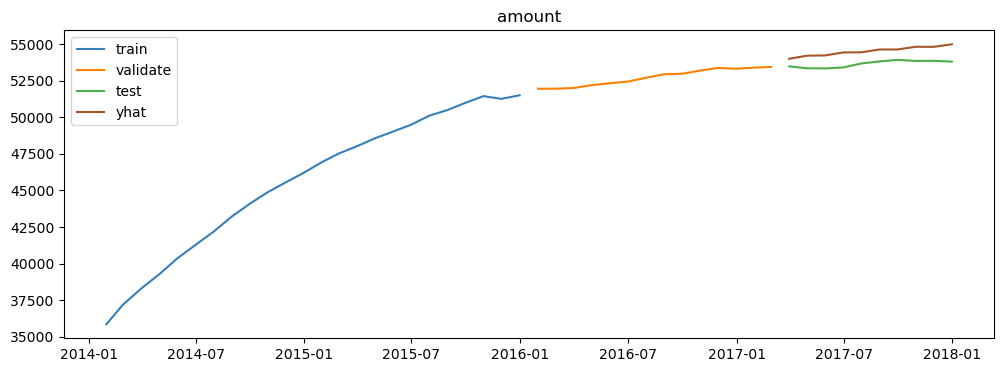

In [114]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-amount: ', rmse_amount)
for col in train.columns:
    final_plot(col)

### Forcasting Into Future

In [ ]:
forecast = pd.DataFrame({'amount': hst_amount_fit3.forecast(validate.shape[0] + test.shape[0] + 365),})
forecast = forecast['2018':]
forecast

In [ ]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

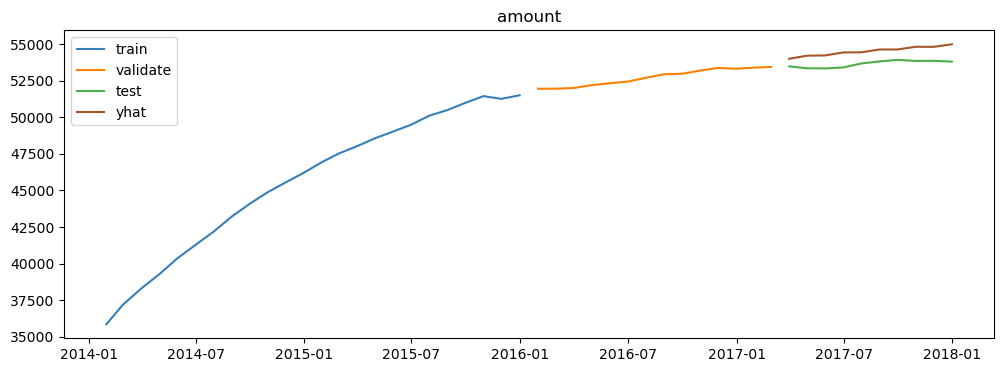

In [115]:
for col in train.columns:
    final_plot(col)